# Tensor Fusion Model - CMU-MOSEI

In [ ]:
!git clone https://github.com/M-Jafarkhani/Multimodal-Emotion-Recognition

In [3]:
import gdown

file_id = "180l4pN6XAv8-OAYQ6OrMheFUMwtqUWbz"
destination = "mosei_senti_data.pkl" 

gdown.download(
    f"https://drive.google.com/uc?id={file_id}", destination, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=180l4pN6XAv8-OAYQ6OrMheFUMwtqUWbz
From (redirected): https://drive.google.com/uc?id=180l4pN6XAv8-OAYQ6OrMheFUMwtqUWbz&confirm=t&uuid=10d49ea9-8e5e-4a51-8b78-80f8e7f1ea95
To: /content/mosei_senti_data.pkl
100%|██████████| 3.73G/3.73G [00:24<00:00, 153MB/s]


'mosei_senti_data.pkl'

## Importing Libraries

In [4]:
import sys
import torch
import matplotlib.pyplot as plt

sys.path.append('/content/Multimodal-Emotion-Recognition/src')

## Importing Helper Functions

In [5]:
from loader import get_dataloader
from unimodals.modules import GRUWithLinear, MLP
from fusions.modules import TensorFusion
from training.supervised import train, test
from utils import get_default_device, save_results

## Loading the Dataset

In [9]:
FILE_PATH = '/content/mosei_senti_data.pkl'
train_data, valid_data, test_data = get_dataloader(FILE_PATH)

In [10]:
device = get_default_device()
print(device)

cuda


## Model Architecture

In [11]:
encoders = [
    GRUWithLinear(35, 64, 4, dropout=True, has_padding=True).to(device),
    GRUWithLinear(74, 128, 19, dropout=True, has_padding=True).to(device),
    GRUWithLinear(300, 512, 79, dropout=True, has_padding=True).to(device),
]

head = MLP(8000, 512, 1).to(device)

fusion = TensorFusion().to(device)

## Training

In [12]:
OUTPUT_MODEL_FILE_NAME = 'MOSEI_Tensor_Fusion'

In [14]:
train_losses, valid_losses = train(
    encoders,
    fusion,
    head,
    train_data,
    valid_data,
    50,
    task="regression",
    optimtype=torch.optim.AdamW,
    early_stop=True,
    is_packed=True,
    lr=1e-3,
    save=f"/content/{OUTPUT_MODEL_FILE_NAME}.pt",
    weight_decay=0.01,
    objective=torch.nn.L1Loss(),
)


Epoch [1/50]
Train Loss: 0.7296
Valid Loss: 0.6187
Saving Best

Epoch [2/50]
Train Loss: 0.6488
Valid Loss: 0.6231

Epoch [3/50]
Train Loss: 0.6064
Valid Loss: 0.6104
Saving Best

Epoch [4/50]
Train Loss: 0.5749
Valid Loss: 0.6038
Saving Best

Epoch [5/50]
Train Loss: 0.5427
Valid Loss: 0.6034
Saving Best

Epoch [6/50]
Train Loss: 0.5014
Valid Loss: 0.6060

Epoch [7/50]
Train Loss: 0.4571
Valid Loss: 0.6008
Saving Best

Epoch [8/50]
Train Loss: 0.4093
Valid Loss: 0.6171

Epoch [9/50]
Train Loss: 0.3736
Valid Loss: 0.6073

Epoch [10/50]
Train Loss: 0.3413
Valid Loss: 0.6028

Epoch [11/50]
Train Loss: 0.3158
Valid Loss: 0.6055

Epoch [12/50]
Train Loss: 0.2933
Valid Loss: 0.6118

Epoch [13/50]
Train Loss: 0.2761
Valid Loss: 0.6220

Epoch [14/50]
Train Loss: 0.2591
Valid Loss: 0.6012

Epoch [15/50]
Train Loss: 0.2477
Valid Loss: 0.6093

Epoch [16/50]
Train Loss: 0.2377
Valid Loss: 0.6237

Epoch [17/50]
Train Loss: 0.2286
Valid Loss: 0.6237

Epoch [18/50]
Train Loss: 0.2198
Valid Loss: 0.6

Text(0.5, 1.0, 'Loss vs. No. of epochs')

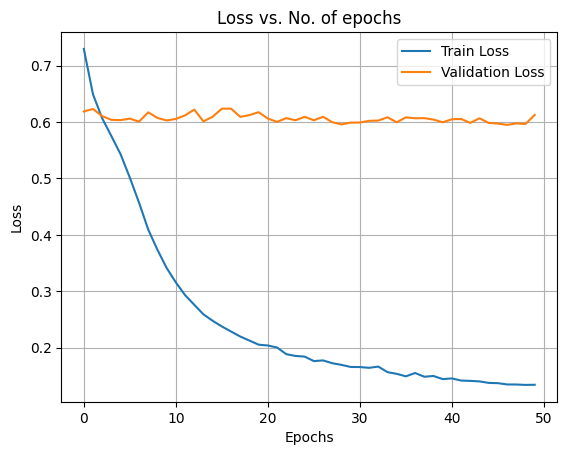

In [15]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Loss vs. No. of epochs')

In [16]:
save_results(train_losses, valid_losses, f'/content/{OUTPUT_MODEL_FILE_NAME}.pkl')

## Testing

In [17]:
model = torch.load(f"/content/{OUTPUT_MODEL_FILE_NAME}.pt").to(device)

test(
    model,
    test_dataloaders_all=test_data,
    is_packed=True,
    criterion=torch.nn.L1Loss(),
    task="posneg-classification"
)


<ipython-input-17-29e99e8281bb>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f'/content/{OUTPUT_MODEL_FILE_NAME}.pt').to(device)


Recall: 79.6409% | Total Accuracy: 70.4501%
Inference Time: 1s610ms
Inference Params: 5488295
